## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno, np. Hamminga (`np.hamming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:

        hamming2d = np.outer(hamming, hamming)

5. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam, jak zdefiniowany w punkcie pierwszym.

6. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru, wykorzystuje się dodatkowe rotacje i przesunięcia:

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

7. Aby otrzymać poprawny filtr, należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

8. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

9. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeni częstotliwości wygenerowanej w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/'
fileNames = ["lena.bmp"]

for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)

In [2]:
# rozmiar filtra
SIZE = 21

# okno Hamminga
hammingWindow = np.hamming(SIZE)

# okno 2D
hammingWindow2D = np.outer(hammingWindow, hammingWindow)

In [3]:
# analogicznie jak w poprzednim ćwiczeniu
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(SIZE))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, SIZE]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(SIZE))
FSpaceColsM = np.outer(np.ones([1, SIZE]), FSpaceCols)
FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

# filtr dolnoprzepustowy
FilterF = FreqR <= 0.1

In [4]:
# zgodnie z instrukcją
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3), flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

# przemnożenie filtra przez okno
FilterFI = FilterFI * hammingWindow2D

In [5]:
# wczytanie obrazu
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

# wymiary obrazu
lenaH, lenaW = lena.shape

# wymiary paddingu
quotH = (lenaH - SIZE) // 2
modH = (lenaH - SIZE) % 2
quotW = (lenaW - SIZE) // 2
modW = (lenaW - SIZE) % 2

# rozszerzenie filtra
FilterFIPad = cv2.copyMakeBorder(FilterFI, quotH + modH, quotH, quotW + modW, quotW, cv2.BORDER_CONSTANT, value=0)

In [6]:
# transformata Fouriera filtra
FilterFIPadF = cv2.dft(np.float32(FilterFIPad), flags=cv2.DFT_COMPLEX_OUTPUT)

# przesunięcie F-obrazu
FilterFIPadFShift = np.fft.fftshift(FilterFIPadF, [0, 1])

# wartość bezwzględna
FilterFinal = np.sqrt(np.square(FilterFIPadFShift[:, :, 0]) + np.square(FilterFIPadFShift[:, :, 1]))

In [7]:
# przestrzeń częstotliwości
size = FilterFinal.shape
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(size[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, size[1]]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(size[1]))
FSpaceColsM = np.outer(np.ones([1, size[0]]), FSpaceCols)

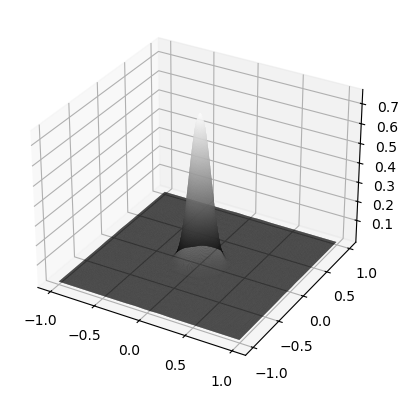

In [8]:
# wyświetlanie filtra
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterFinal, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
plt.show()

In [9]:
# przeprowadzenie filtracji
# powielenie filtru na 2 kanały
FilterF3 = np.repeat(FilterFinal[:, :, np.newaxis], 2, axis=2)

# transformata Fouriera obrazu i przesunięcie
lenaF = cv2.dft(np.float32(lena), flags=cv2.DFT_COMPLEX_OUTPUT)
lenaFShift = np.fft.fftshift(lenaF, [0, 1])

# przemnożenie obrazu przez filtr
lenaFShiftFilter = lenaFShift * FilterF3

# odwrotne przesunięcie i transformata
lenaFIfft = np.fft.ifftshift(lenaFShiftFilter, [0, 1])
lenaIfft = cv2.idft(lenaFIfft, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)

# pozbycie się małej części urojonej i zaokrąglenie wyniku
lenaIfft = cv2.magnitude(lenaIfft[:, :, 0], lenaIfft[:, :, 1])
lenaIfft = np.round(lenaIfft).astype(np.uint8)

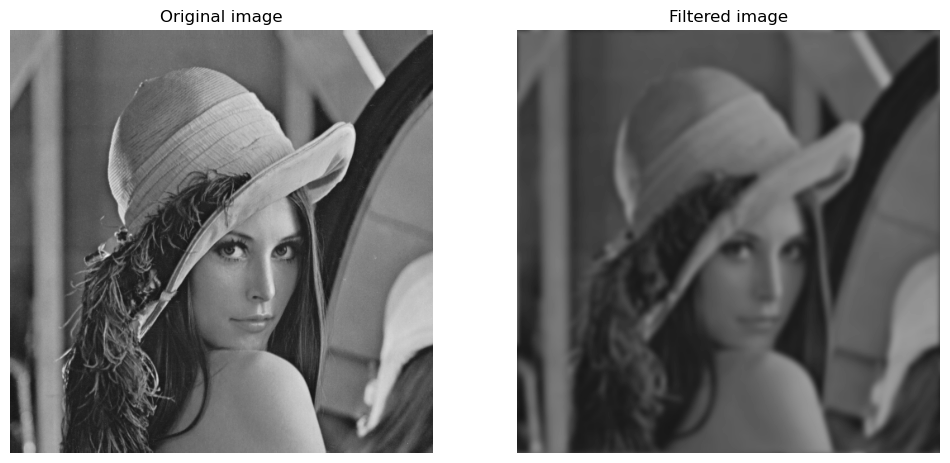

In [10]:
# wyświetlenie oryginalnego obrazka i wyniku filtracji
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

axs[0].set_title("Original image")
axs[0].imshow(lena, 'gray', vmin=0, vmax=256)
axs[0].axis('off')

axs[1].set_title("Filtered image")
axs[1].imshow(lenaIfft, 'gray', vmin=0, vmax=256)
axs[1].axis('off')

plt.show()